# When is OLS biased due to lack of common support, compared to coarsened matching?

**Author**: Mihaly Hanics

## Intro - discussions

The way OLS can be considered biased is in the case of the omitted variable bias (OVB) - when missing a variable that is correlated with `y`, and also correlated with `x`. This is a general issue, not specific to the lack of common support, but lack of common support can bias OLS through OVB. I'll highlight how it is relevant in our case.

Before I highlight an example with OLS lack of common support bias, let's first look at OVB.

### A simple example of **omitted variable bias**

Imagine a very simplified, just representative example:

(`y`): global temperature<br>
(`x`): $CO_2$ emissions in 10Gt in the past year (countries typically emit 5-10 tons per capita per year)<br>
(`z`): absorption capacity decline measure: how much less can we absorb $CO_2$ (compared to if there were no emissions)

<br>Both `x` and `z` cause are positively correlated with `y`. In order to have OVB, `z` and `x` must also be correlated, which I will implement artificially.<br>
The idea is that even if `z` can store some information about the `y`, that information is not captured by the `x` variable. And since `x` is correlated with `z`, the "makeup-correlation" will systematically change the OLS estimate of the `x` coefficient - i.e., cause a bias due to lack of `z`.

For the sake of the example, let's assume we can describe the exact relationship between `x` and `y` as $y = x + z$ (this is wrong of course, but can help to illustrate the OVB; don't need an error term for the example).

I define the `z` variable as fraction of `x` + some uniform noise: $z = 0.2*x + 0.8*\epsilon$, where $\epsilon \sim U(0,1)$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

fig = plt.figure(figsize=(15, 5))

n = 10000
co2 = np.linspace(0, 1, n)
absorption_capacity_decline = 0.2 * co2 + 0.8 * np.random.random(n)
#co2, absorption_capacity_decline = np.meshgrid(co2, absorption_capacity_decline)
temp = co2 + absorption_capacity_decline

<Figure size 1500x500 with 0 Axes>

It's good to visualize the relationship (note I used temperature as z-axis variable here):

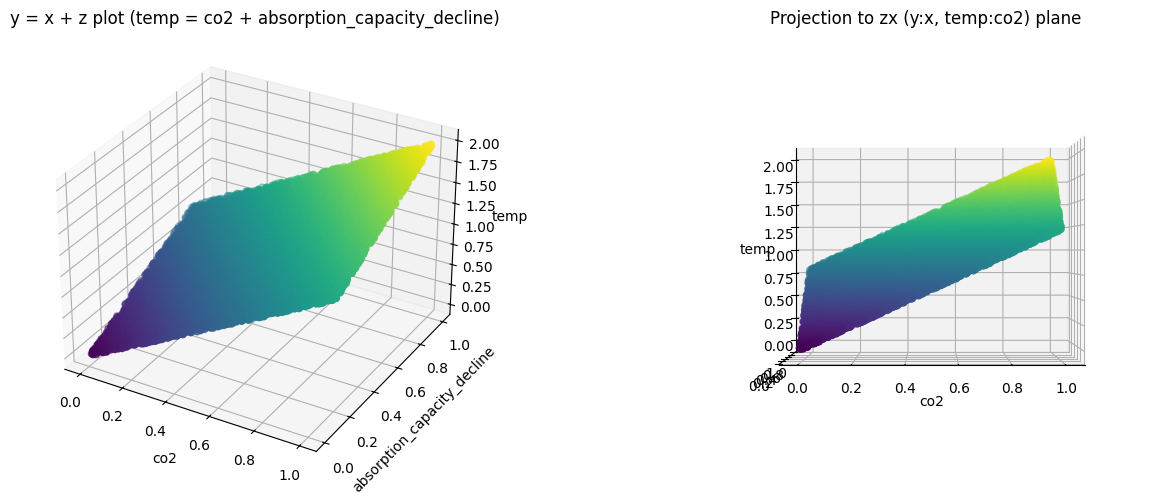

In [2]:
fig = plt.figure(figsize=(15, 5))

ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(co2, absorption_capacity_decline, temp, c=temp, cmap='viridis')
ax1.set_title('y = x + z plot (temp = co2 + absorption_capacity_decline)')
ax1.set_xlabel('co2')
ax1.set_ylabel('absorption_capacity_decline')
ax1.set_zlabel('temp')

ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(co2, absorption_capacity_decline, temp, c=temp, cmap='viridis')
ax2.view_init(0, -90)
ax2.set_title('Projection to zx (y:x, temp:co2) plane')
ax2.set_xlabel('co2')
#ax2.set_ylabel('absorption_capacity_decline')
ax2.set_zlabel('temp')
#diagonal_line = ax2.plot([0.0,1], [0,0], [0.5,1.7], color='red', linestyle='--', linewidth=2)

plt.tight_layout()
plt.show()

The left plot shows the function, whereas the right plot represents what we see when ignoring `z` - by projecting the data to the `y-x` plane (ignoring the dimension of z).


As `y` is defined as `x + z`, the true slope ($\beta_1$ coefficient) is 1 (as is $\beta_2$). However, when we look at the right plot we see that in fact, temperature seems to grow by 1.2 times the $CO_2$ increase - e.g. the maximum temperature at $CO_2=0$ is $T=0.8$, whereas at $CO_2=1$ it is $T=2$. (From the plot we cannot read the distribution densities and hence "read the OLS slope", but we know that density is uniform from the definition and the slope is the same everywhere - 1.2).

Let's see if this is correct by fitting the OLS model:

In [3]:
X1 = co2.reshape(-1, 1)
y = temp.reshape(-1, 1)

ols1 = LinearRegression()
ols1.fit(X1, y)
print(f"OLS without z: x coefficient (biased): {ols1.coef_[0][0]:.2f}")

#Regression with both x and z
X2 = np.column_stack((co2, absorption_capacity_decline))
ols2 = LinearRegression()
ols2.fit(X2, y)
print(f"OLS with z: x coefficient (biased): {ols2.coef_[0][0]:.2f}")

OLS without z: x coefficient (biased): 1.21
OLS with z: x coefficient (biased): 1.00


Indeed, the slope when not considering `z` is 1.2, which is not the true value of 1. This is a bias.<br>
We can prove this generally by just modeling `z` with `x` ($z = \gamma\cdot x + e$):

$y = \beta_0 + \beta_1\cdot x + \beta_2\cdot z = \beta_0 + \beta_1\cdot x + \beta_2\cdot (\gamma\cdot x + e) = (\beta_0 + \beta_2\cdot e) + (\beta_1 + \beta_2\cdot \gamma)\cdot x$,

from this we can see that without `z`, the OLS slope will be $\beta_1 + \beta_2\cdot \gamma$, increasing by $\beta_2\cdot \gamma$, in our case by $1\cdot0.2 = 0.2$.

### How does this relate to OLS lack of common support when causally inferring?

During causal inference, we have to condition on confounders ($z_i$ values) and their values, however this may not always be completely available - e.g. combination of some subcategories of $z$ values may not be present in data, hence lack of common support. If the complete spectrum of a $z$ variable is not available, but some parts are missing, that can lead to the same issue as above - the OLS estimate will be biased due to the omitted variable bias.

## OLS bias due to lack of common support - an example

Let's create an example that will be biased due to lack of common support:

**Effect on income by living in a capital**

- `log_y`: log10 of annual income
- `x`: living in a capital (binary)
- `z1`: age category (20-29, 30-39, 40-49, 50-59) (0-3)
- `z2`: job responsibility, from 0 to 10

Both `z1` and `z2` could be considered as confounders, first being a common cause of `x` and `log_y`, and the second being an unwanted mechanism (or even a common cause).

In order to observe a bias, we need some correlation between `z` values and `x`. I artificially create `z1` to be correlated with `x`. This is how every I construct a `z1` value for every `x`:<br>
$z1 = [4 \cdot (0.4 \cdot x + 0.6 \cdot U(0,1))]$ ([] is the floor function). Higher the value of $z1$, higher the likeliness that it was generated by a capital resident ($x=1$).

To have lack of common support, I construct every `z2` value differently based on the corresponding `z1` value:<br>
- if `z1` is 0, sample `z2` from a $N(2,1.5)$ distribution (limited to 0-10, and rounded down to integer)
- if `z1` is 1, sample `z2` from a $N(5,1)$ distribution
- if `z1` is 2, sample `z2` from a $N(7,1)$ distribution
- if `z1` is 3, sample from [6, 8, 9, 9, 10]

This way, many combinations of `z1` and `z2` values will be missing. With $x=0$, `z1` tends to be small and hence `z2` aswell, whereas with $x=1$ we get larger `z1, z2` values - leaving room for lack of common support.


To certainly know what the true effect of `x` on `log_y` is, I do not define `y` via an independent mechanism (e.g. sampling from a lognormal distribution), but rather define it as a function of `x`, `z1` and `z2`:<br>

$log_y = 4.3 + 0.3\cdot x + 0.3\cdot \frac{z1}{3} + 0.1\cdot (\frac{z2}{5})^3$

The coefficients of $0.3$ resemble a doubling of income ($log_{10}2 \approx 0.3$), thus living in the capital and being in the oldest age category could double the income (twice). The increase from `z2` is 0.8 maximum, meaning a roughly 6.25 times increase in income. The use of a cubic function increases OLS bias. $\beta_0 = 4.3$ to have a minimum income of roughly 20k$, and with a $2\cdot2\cdot6.25=25$ times increase, the maximum income is roughly 500k$.

Logically, by definition, $\beta_1$ must be 0.3, because assuming the same `z` values, the increase in `log_y` is determined only by the unit increase in `x`, which here is always 0.3. Matching will compute the weighted average of these differences, which of course will be 0.3, despite having completely different distributions of `z1` and `z2` for `x=0` and `x=1` (and some combinations will not be present). OLS will not be able to account for this, and will be biased.

Let's create our data:

In [4]:
n = 100
np.random.seed(20001104)
x = np.random.binomial(1, 0.5, n)
z1 = np.floor(4 * (0.4 * x + 0.6 * np.random.random(n)))
z2 = np.zeros(n)
for i in range(n):
    if z1[i] == 0:
        z2[i] = np.floor(np.clip(np.random.normal(2, 1.5), 0, 10))
    elif z1[i] == 1:
        z2[i] = np.floor(np.clip(np.random.normal(5, 1), 0, 10))
    elif z1[i] == 2:
        z2[i] = np.floor(np.clip(np.random.normal(7, 1), 0, 10))
    else:
        z2[i] = np.random.choice([6, 8, 9, 9, 10])

log_y = 4.3 + 0.3*x + 0.3*(z1/3) + 0.1*(z2/5)**3 #see that for any matching, the difference is 0.3 + random noise

Distribution of synthetic income data (from ~20k to ~500k), and distribution of (`z1`, `z2`) pairs:

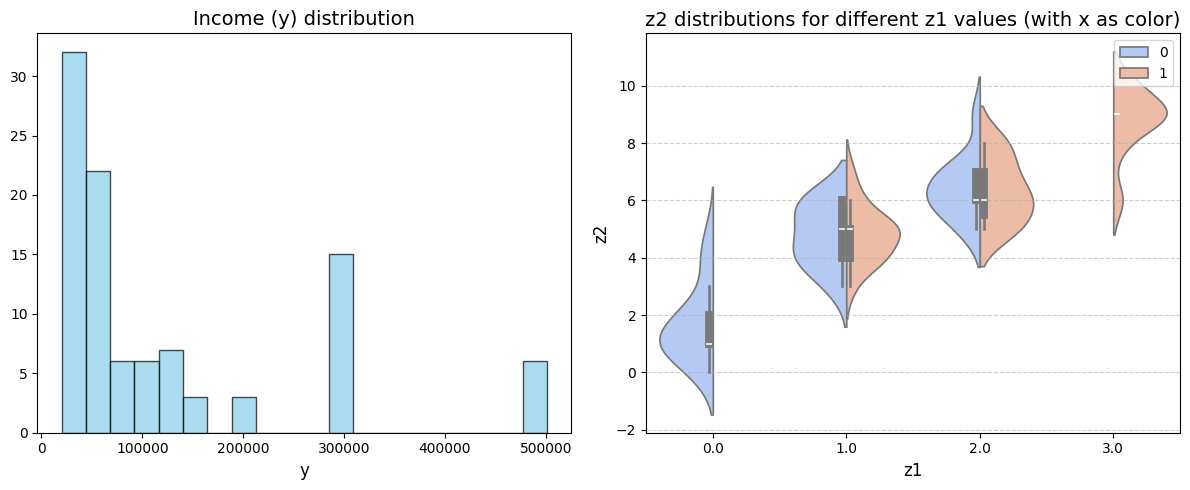

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(12, 5),)
axes[0].hist(10**(log_y), bins=20, color='skyblue', edgecolor='black', alpha=0.7)
axes[0].set_title("Income (y) distribution", fontsize=14)
axes[0].set_xlabel("y", fontsize=12)

sns.violinplot(
    ax=axes[1], x=z1, y=z2, inner="box", density_norm="width",
    palette="coolwarm", hue=x, split=True
)
axes[1].set_title("z2 distributions for different z1 values (with x as color)", fontsize=14)
axes[1].set_xlabel("z1", fontsize=12)
axes[1].set_ylabel("z2", fontsize=12)
axes[1].grid(axis="y", linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()

In [6]:
def compute_equation(x,z1,z2):
    log_y = 4.4 + 0.3*x + 0.3*(z1/3) + 0.7*(z2/10)**2
    return log_y

def exact_matching(xs, z1s, z2s, ys, silent = False):
    z1_values = list(set(z1s))
    z2_values = list(set(z2s))
    cell_diffs = {}
    for z1 in z1_values:
        for z2 in z2_values:
            group_nontreated = (z1s == z1) & (z2s == z2) & (xs == 0)
            group_treated = (z1s == z1) & (z2s == z2) & (xs == 1)
            y_group1 = ys[group_treated]
            y_group0 = ys[group_nontreated]
            if len(y_group1) > 0 and len(y_group0) > 0:
                cell_diffs[(z1, z2)] = {"diff": y_group1.mean() - y_group0.mean(), "observations": len(y_group1) + len(y_group0)}
            elif len(y_group1) > 0:
                if not silent:
                    print(f"No common support for z1={z1}, z2={z2}, only treated group (x=1) has observations")
            elif len(y_group0) > 0:
                if not silent:
                    print(f"No common support for z1={z1}, z2={z2}, only non-treated group (x=0) has observations")
    weighted_diff = sum([cell["diff"] * cell["observations"] for cell in cell_diffs.values()]) / sum([cell["observations"] for cell in cell_diffs.values()])
    return weighted_diff

matching_estimate = exact_matching(x, z1, z2, log_y)
print(f"\nExact matching estimate (only comparing cells with both groups present): {matching_estimate:.3f}") #will always be 0.3
# OLS estimation
X = np.column_stack([x, z1, z2])
ols = LinearRegression()
ols.fit(X, log_y)
print(f"OLS coefficient for x: {ols.coef_[0]:.3f} (decrease of {100*(ols.coef_[0]-0.3)/0.3:.2f}%)")

No common support for z1=0.0, z2=0.0, only non-treated group (x=0) has observations
No common support for z1=0.0, z2=1.0, only non-treated group (x=0) has observations
No common support for z1=0.0, z2=2.0, only non-treated group (x=0) has observations
No common support for z1=0.0, z2=3.0, only non-treated group (x=0) has observations
No common support for z1=0.0, z2=4.0, only non-treated group (x=0) has observations
No common support for z1=0.0, z2=5.0, only non-treated group (x=0) has observations
No common support for z1=1.0, z2=7.0, only treated group (x=1) has observations
No common support for z1=2.0, z2=8.0, only treated group (x=1) has observations
No common support for z1=2.0, z2=9.0, only non-treated group (x=0) has observations
No common support for z1=3.0, z2=6.0, only treated group (x=1) has observations
No common support for z1=3.0, z2=8.0, only treated group (x=1) has observations
No common support for z1=3.0, z2=9.0, only treated group (x=1) has observations
No common su

We see that matching did indeed find the true effect of 0.3, whereas OLS estimated 0.277, despite confounders being controlled for. This is a bias due to lack of common support: the distribution of `z1` and `z2` values are different for `x=0` and `x=1`, with many combinations missing entirely. This was not a problem for matching.<br>
Also, matching has no issue with nonlinear relationships, unlike OLS.

The simulation successfully recreated a situation where OLS will be biased due to lack of common support.

## Use of AI:

- Helped brainstorm ideas on what variables could be relevant after I ran out of ideas
- Helped with the violin plot visualization in Seaborn

Both of these were conveyed with ChatGPT 4o.